In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score,r2_score
 

In [3]:
path = "fashion-mnist.csv"
path_test = "fashion-mnist_test.csv"

df = pd.read_csv(path) #Dataset dado por la catedra
df_test = pd.read_csv(path_test) #Dataset de testeo
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Funciones

Funcion para ver alguna imagen de la clase elegida

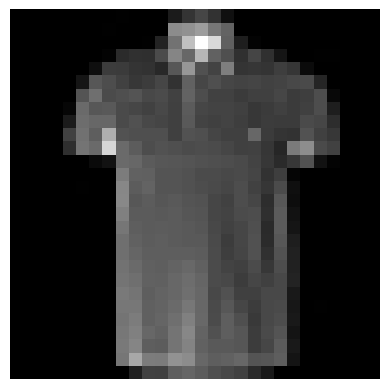

In [4]:
def mostrarImagenDe (label: int):
    clase = df[df['label'] == label].drop(columns='label')
    imagen = clase.iloc[np.random.randint(0,6000)].values.reshape(28,28)
    sns.heatmap(data=imagen, cmap='gray',cbar=False, square=True,annot=False,xticklabels=[],yticklabels=[])
    plt.show()
    plt.close()

mostrarImagenDe(0)

Funcion que me devuelve la imagen promedio de una clase en particular

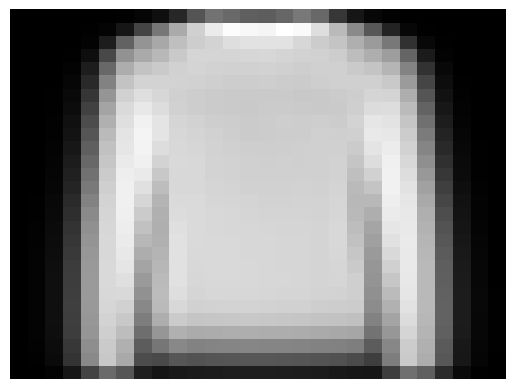

In [5]:
def promedioImagen(prenda:int):
    clase = df[df['label']== prenda].drop(columns='label')
    promedio_imagen = np.mean(clase.values,axis=0)
    promedio_imagen /= len(df[df['label']  == prenda])
    promedio_imagen = promedio_imagen.reshape(28,28)
    sns.heatmap(data=promedio_imagen, cmap='gray',cbar=False, xticklabels=[],yticklabels=[])
    
promedioImagen(2)

Graficar Scores

In [6]:
def graficarScores(scores1, scores2,k):
    k_fold = [f'Pliegue {i+1}' for i in range(k)]*2
    data = {
        'Fold': k_fold,
        'Modelo': ['Rem y Pant']*k + ['Rem y Pull']*k,
        'Precisión': np.concatenate((scores1,scores2))
    }
    df = pd.DataFrame(data)

    plt.figure(figsize=(10,6))
    sns.barplot(data=df,x='Fold',y='Precisión', hue='Modelo')
    plt.xlabel('Plieges')
    plt.ylabel('Precisión')
    plt.title('Comparacion de precisión entres remeras con pantalones y remeras con pullovers')
    plt.legend(title='Modelos')
    plt.show()
    plt.close()

Validacion Cruzada

In [7]:
def validacion_cruzada(model,X,Y,K):
    cv = KFold(n_splits=K,shuffle=True,random_state=42)
    scores = cross_val_score(model,X,Y, cv=cv, scoring='accuracy')
    return scores

Testeo de modelos segun set de datos de entrenamiento

In [8]:
def testearModelo (modelo,x,y):
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2, shuffle=True) #Aca separo el dataset en train y val
    modelo.fit(x_train, y_train)
    y_predict = modelo.predict(x_val)
    return accuracy_score(y_val,y_predict)

Calibracion de modelos

In [9]:
def calibrar(model,x,y):
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2, shuffle=True)
    model.fit(x_train,y_train)
    best_param = model.best_params_
    best_model = model.best_estimator_
    accuracy = best_model.score(x_val,y_val)
    print(f"El mejor k es: {best_param}, con una precision de: {accuracy} ")

## Ejercicios

### Ejercicio 1.b ¿Hay clases de prendas que son parecidas entre si?

Cuando comparamos entre remaras y pantalones, la precision de clasificacion es mayor que cuando se intenta clasificar remeras y pullover. Por lo que clasificar los distintos tipos de prendas presenta cierta dificultad segun entre que prendas se compare. 

In [10]:
remYpants = df[(df['label'] == 1) | (df['label'] == 0)] #dataset de remeras y pantalones
Y = remYpants['label']
X = remYpants[['pixel1','pixel196','pixel350']] #solo le damos 3 pixeles para que entrene
k = 5
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.2,shuffle=True)

neigh = KNeighborsClassifier(n_neighbors=k)
score1 = validacion_cruzada(neigh,X,Y,k)

print(f"La precision cuando se comparan remeras con pantalones es de : {np.mean(score1)}")

La precision cuando se comparan remeras con pantalones es de : 0.6076666666666666


In [11]:
remYpull = df[(df['label']== 0) | (df['label']== 2)]
X1 = remYpull[['pixel1','pixel196','pixel350']]
Y1 = remYpull['label']

x1_train, x1_val, y1_train, y1_val = train_test_split(X1,Y1, test_size=0.2, shuffle=True)

neigh2 = KNeighborsClassifier(n_neighbors=k)
score2 = validacion_cruzada(neigh2,X1,Y1,k)
print(f"La precision cuando se comparan remeras con pullovers es de : {np.mean(score2)}")

La precision cuando se comparan remeras con pullovers es de : 0.5154166666666666


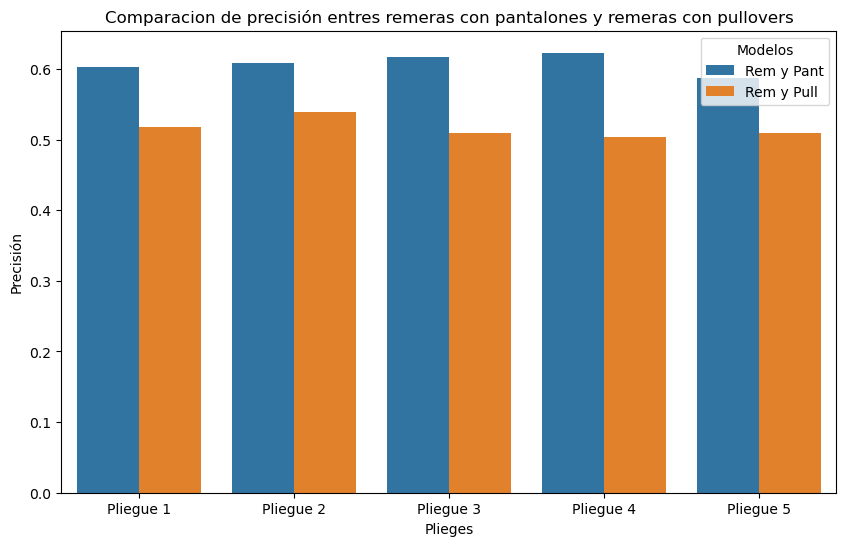

In [12]:
graficarScores(score1,score2,k)

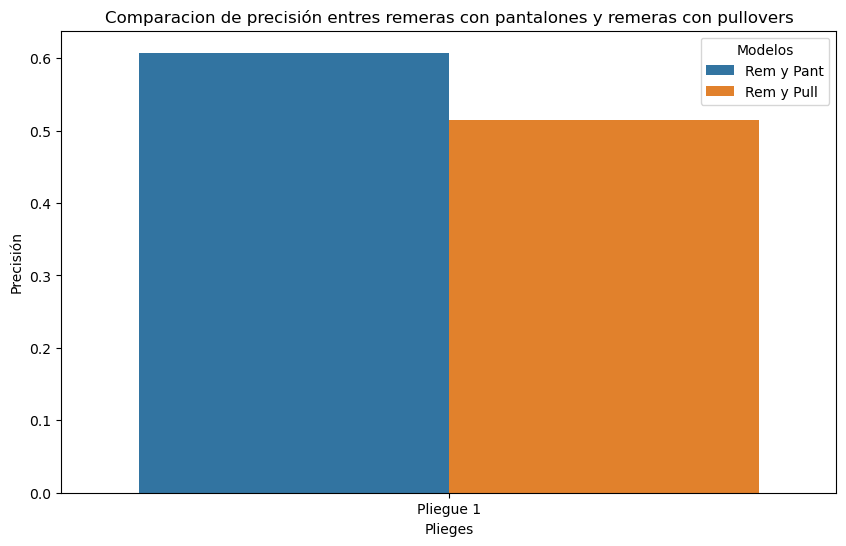

In [14]:
graficarScores([np.mean(score1)],[np.mean(score2)],1)

### Ejercicio 2

2.a) Creo los DataFrames de pantalones y remeras

In [14]:
pantalones = df[df['label'] == 1].drop(columns='label')
remeras = df[df['label'] == 0].drop(columns='label')

2.b) Aca podemos ver que cada conjunto de datos de cada clase tiene la misma cantidad de muestras por lo que podemos decir que esta balanceado

In [15]:
print("Cantidad de muestras en pantalones: ", len(pantalones))
print("Cantidad de muestras en remeras: ", len(remeras))

Cantidad de muestras en pantalones:  6000
Cantidad de muestras en remeras:  6000


2.c) Propusimos 3 conjuntos de 3 atributos distintos y 2 de 4 para comparar distintos modelos KNN. En la funcion `testearModelo()` se divide el data set en train y val y nos devuelve la precision de ese modelo. Se observa que el set de datos `Xd` que se compone de las columas `cols4` que representan la diagonal con 4 pixeles ya consigue una precision muy buena. Cuando se entrena con todas las columnas el modelo consigue una precision casi perfecta

In [23]:
#aca proponemos 5 conjunto de atributos distintos

cols1 =['pixel1','pixel2','pixel3'] #primeros 3 pixeles de la esquina superior izquierda
cols2 = ['pixel14','pixel210','pixel406'] # recta vertical en el medio de la imagen
cols3 = ['pixel1','pixel175','pixel378'] # diagonal desdes esquina superior izquierda hasta esquina inferior derecha
cols4 = ['pixel1','pixel175','pixel378','pixel581'] #diagonal con 1 pixel mas
cols5 = ['pixel14','pixel210','pixel406','pixel602'] #Recta vertical con 1 pixel mas


Xa = remYpants[cols1]
Xb = remYpants[cols2]
Xc = remYpants[cols3]
Xd = remYpants[cols4]
Xf = remYpants[cols5]
Xg = remYpants.drop(columns='label') # Set de entrenamiento con todas las columnas de pixeles
Ys = remYpants['label']

knn5 = KNeighborsClassifier(n_neighbors=5)

puntajeA = testearModelo(knn5,Xa,Ys)
puntajeB = testearModelo(knn5,Xb,Ys)
puntajeC = testearModelo(knn5,Xc,Ys)
puntajeD = testearModelo(knn5,Xd,Ys)
puntajeJ = testearModelo(knn5,Xf,Ys)
puntajeG = testearModelo(knn5,Xg,Ys)

#Aca testeo un modelo knn de 5 vecinos con los diferentes conjuntos de test
print(f"La precision del modelo knn5 con el dataset Xa es de: {puntajeA}")
print(f"La precision del modelo knn5 con el dataset Xb es de: {puntajeB}")
print(f"La precision del modelo knn5 con el dataset Xc es de: {puntajeC}")
print(f"La precision del modelo knn5 con el dataset Xd es de: {puntajeD}")
print(f"La precision del modelo knn5 con el dataset Xf es de: {puntajeJ}")
print(f"La precision del modelo knn5 con el dataset Xg es de: {puntajeG}")

La precision del modelo knn5 con el dataset Xa es de: 0.53125
La precision del modelo knn5 con el dataset Xb es de: 0.825
La precision del modelo knn5 con el dataset Xc es de: 0.9029166666666667
La precision del modelo knn5 con el dataset Xd es de: 0.93
La precision del modelo knn5 con el dataset Xf es de: 0.8866666666666667
La precision del modelo knn5 con el dataset Xg es de: 0.9875


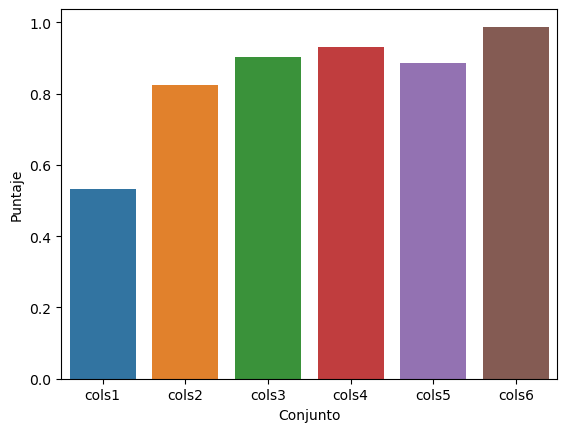

In [27]:
dataEJ1 = {'Conjunto': ["cols1","cols2","cols3","cols4","cols5","cols6"], 'Puntaje': [puntajeA,puntajeB,puntajeC,puntajeD,puntajeJ,puntajeG] }

puntajes1a = pd.DataFrame(dataEJ1)

sns.barplot(data=puntajes1a, x='Conjunto', y='Puntaje')
plt.show()
plt.close()

2.d) En este punto queremos calibrar los modelos que estuvimos comparando para con que hiperparametro conseguimos una mejor precision. Con la funcion `calibrar()` vamos calibrando el `grid_search` que inicializamos para que segun el set de datos presentado nos proporcione la cantidad de vecinos mas optima. Otra vez el modelo entrenado con el set de datos `Xd` es el que saca mas precision con 

In [17]:
knn = KNeighborsClassifier()
hiper_grid = {'n_neighbors':[1,2,3,4,5,6,7,9,10,11,12,13,14,15,20,25,30]}

grid_search = GridSearchCV(knn, hiper_grid, cv=4, scoring='accuracy')

calibrar(grid_search,Xa,Ys)
calibrar(grid_search,Xb,Ys)
calibrar(grid_search,Xc,Ys)
calibrar(grid_search,Xd,Ys)
calibrar(grid_search,Xf,Ys)
calibrar(grid_search,Xg,Ys)

El mejor k es: {'n_neighbors': 12}, con una precision de: 0.5216666666666666 
El mejor k es: {'n_neighbors': 15}, con una precision de: 0.8270833333333333 
El mejor k es: {'n_neighbors': 25}, con una precision de: 0.9108333333333334 
El mejor k es: {'n_neighbors': 30}, con una precision de: 0.9316666666666666 
El mejor k es: {'n_neighbors': 9}, con una precision de: 0.8975 


Para terminar testeamos el modelo elegido, un KNN con k=12 segun la calibracion de hiperparametros, entrenado con todo el set de entreamiento de datos que mejor precision nos devolvio, en este caso el conjunto `cols4`. Para hacer la prediccion utilizamos el set de datos de test que conseguimos https://www.kaggle.com/datasets/zalando-research/fashionmnist a modo de holdout.

In [18]:
knn = KNeighborsClassifier()
remYpants_test = df_test[(df_test['label'] == 1) | (df_test['label'] == 0)]
X_test = remYpants_test[cols4]
Y_test = remYpants_test['label']
k = 12

knn_final = KNeighborsClassifier(n_neighbors=k)
knn.fit (Xd, Ys) # Entreno el modelo final con todo el set de la diagonal de 4 pixeles
y_predict_final = knn.predict(X_test) # Hago la prediccion final sobre el set de datos de testeo

print(f"La precision dle modelo final con k=12 entredado con el conjunto de training (Xd,Ys) es de: {accuracy_score(Y_test, y_predict_final)}")

La precision dle modelo final con k=12 entredado con el conjunto de training (Xd,Ys) es de: 0.9385


### Ejercicio 3

3.a) Dado que decidimos usar un nuevo set para la evaluacion del modelo omitimos elte paso

3.b) Separamos el dataset para analizar distintas profundidades de arboles

In [19]:
X = df.drop(["label"], axis=1)
Y = df[['label']]

In [20]:
tree = DecisionTreeClassifier()
hyper_params = {
    'criterion' : ["gini", "entropy"],
    'max_depth' : [5,8,10,12,14,15,20,25,30]
    }
clf = RandomizedSearchCV(tree, hyper_params, random_state=0)
search = clf.fit(X, Y)
print(search.best_params_)
print(search.best_score_)

KeyboardInterrupt: 

dados los mejores parametros para el arbol de decision, usamos profundidades cercanas para evaluarlos con kfolding

In [21]:
#usamos 5 folds
k = 5
tree1 = DecisionTreeClassifier(max_depth=13, criterion="gini")
tree2 = DecisionTreeClassifier(max_depth=14, criterion="gini")
tree3 = DecisionTreeClassifier(max_depth=15, criterion="gini")
score1 = validacion_cruzada(tree1, X, Y, k)
score2 = validacion_cruzada(tree2, X, Y, k)
score3 = validacion_cruzada(tree3, X, Y, k)

In [ ]:
print(f"score tree1 profundidad 13 {np.mean(score1)}")
print(f"score tree2 profundidad 14 {np.mean(score2)}")
print(f"score tree3 profundidad 15 {np.mean(score3)}")

score tree1 profundidad 13 0.8120166666666666
score tree2 profundidad 14 0.8104666666666667
score tree3 profundidad 15 0.8093999999999999


Nuestros mejores criterios fueron max depth 13, criterion gini

Para terminar testeamos el modelo con un set de datos que encontramos en https://www.kaggle.com/datasets/zalando-research/fashionmnist que es puntualmente para el testeo

In [ ]:
best_criterion = "gini"
best_depth = 13

X_eval, Y_eval = df_test.drop(columns=["label"]), df_test[["label"]]

dtc = DecisionTreeClassifier(max_depth=best_depth, criterion=best_criterion)
dtc.fit(X, Y)
pred = dtc.predict(X_eval)

In [ ]:
classrep = classification_report(Y_eval, pred)
accscore = accuracy_score(Y_eval, pred)

print(f"accscore: {accscore}")

print(classrep)

accscore: 0.818
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1000
           1       0.97      0.96      0.96      1000
           2       0.72      0.70      0.71      1000
           3       0.87      0.83      0.85      1000
           4       0.68      0.77      0.72      1000
           5       0.91      0.88      0.90      1000
           6       0.59      0.56      0.57      1000
           7       0.88      0.89      0.88      1000
           8       0.93      0.92      0.92      1000
           9       0.90      0.91      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



<Axes: xlabel='label'>

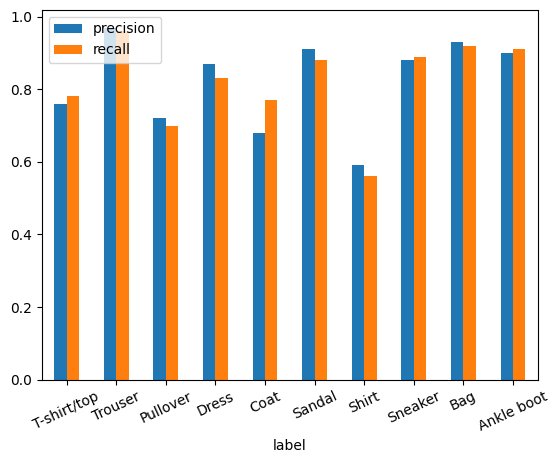

In [ ]:
labels = ["label", "precision", "recall", "f1-score", "support"]
data = [["T-shirt/top", 0.76, 0.78, 0.77, 1000],
        ["Trouser",     0.97, 0.96, 0.96, 1000],
        ["Pullover",    0.72, 0.70, 0.71, 1000],
        ["Dress",       0.87, 0.83, 0.85, 1000],
        ["Coat",        0.68, 0.77, 0.72, 1000],
        ["Sandal",      0.91, 0.88, 0.90, 1000],
        ["Shirt",       0.59, 0.56, 0.57, 1000],
        ["Sneaker",     0.88, 0.89, 0.88, 1000],
        ["Bag",         0.93, 0.92, 0.92, 1000],
        ["Ankle boot",  0.90, 0.91, 0.90, 1000]]

reporteArbol = pd.DataFrame(data=data, columns = labels)
reporteArbol.drop(columns=["f1-score","support"]).plot(kind="bar", x="label", rot=25)

In [ ]:
classrep = classification_report(Y_test, y_predict_final)
print(classrep)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1000
           1       0.94      0.93      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



In [ ]:
dataKnn = [["T-shirt/top", 0.93, 0.94, 0.94, 1000],
           ["Trouser", 0.94, 0.93, 0.94, 1000]]

reporteKnn = pd.DataFrame(data=dataKnn, columns = labels)
reporteKnn

,label,precision,recall,f1-score,support
0,T-shirt/top,0.93,0.94,0.94,1000
1,Trouser,0.94,0.93,0.94,1000


In [ ]:
reporteKnn["modelo"] = ["Knn", "Knn"]
reporteArbolRemPant = reporteArbol.drop(index=[2,3,4,5,6,7,8,9])
reporteArbolRemPant["modelo"] = ["arbol", "arbol"]

reporte = pd.DataFrame(reporteArbolRemPant)
reporte = reporte.append(reporteKnn, ignore_index=True)
reporte = reporte.drop(columns=["f1-score","support"])
reporte

,label,precision,recall,modelo
0,T-shirt/top,0.76,0.78,arbol
1,Trouser,0.97,0.96,arbol
2,T-shirt/top,0.93,0.94,Knn
3,Trouser,0.94,0.93,Knn


In [ ]:
remerasKNN = reporteKnn[reporteKnn["label"]=="T-shirt/top"]
remerasARBOL = reporteArbol[reporteArbol["label"]=="T-shirt/top"]
pantalonesKNN = reporteKnn[reporteKnn["label"]=="Trouser"]
pantalonesARBOL = reporteArbol[reporteArbol["label"]=="Trouser"]

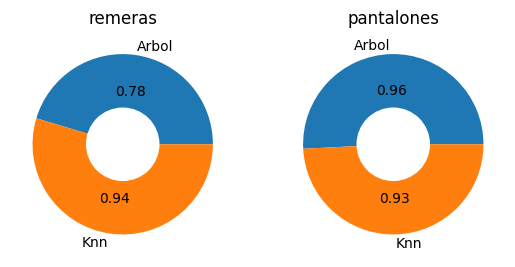

In [ ]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = ((pct*total/100.0))
        #return '{p:.0f}%  ({v:.2f})'.format(p=pct,v=val)
        return '{v:.2f}'.format(p=pct,v=val)
    return my_autopct

def grafCirculo():
    circle=plt.Circle((0,0), 0.4, color='white')
    p=plt.gcf()
    p.gca().add_artist(circle)

keys = ["Arbol", "Knn"]
piedata = [float(remerasARBOL["recall"]), float(remerasKNN["recall"])]

plt.subplot(1,2,1)
plt.pie(piedata, labels=keys, autopct=make_autopct(piedata))
grafCirculo()
plt.title("remeras")


keys = ["Arbol", "Knn"]
piedata = [float(pantalonesARBOL["recall"]), float(pantalonesKNN["recall"])]

plt.subplot(1,2,2)
plt.pie(piedata, labels=keys, autopct=make_autopct(piedata)) 
grafCirculo()
plt.title("pantalones")

plt.show()

In [ ]:
reporte.plot(kind="bar", x="label", hue='model' rot=25)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4217057793.py, line 1)